In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import *

In [2]:
%matplotlib inline

In [3]:
import requests 

In [4]:
from purpleair.network import SensorList #import list of active sensors using PurpleAir API

In [5]:
p = SensorList()

Initialized 20,398 sensors!


In [6]:
from purpleair.sensor import Sensor

In [7]:
last_data = p.to_dataframe(sensor_filter='outside',channel='parent') #import last reading from all outdoor active sensors

In [8]:
areas = pd.DataFrame(columns=['location','lat','lon']) #create a dataframe for the areas we're interested in exploring
areas = areas.append({'location':'lovers_leap','lat':38.799,'lon':-120.141},ignore_index=True) #add the lat/lon for lovers leap
areas = areas.append({'location':'donner_summit','lat':39.33,'lon':-120.335},ignore_index=True)
areas = areas.append({'location':'yosemite','lat':37.74,'lon':-119.573},ignore_index=True)
areas

,location,lat,lon
0,lovers_leap,38.799,-120.141
1,donner_summit,39.330,-120.335
2,yosemite,37.740,-119.573


In [9]:
def aqi_pm2_5(pm2_5): #equations for converting PM2.5 to AQI
    if pm2_5 < 15.5:
        return (50/15)*pm2_5
    elif pm2_5 < 40.5:
        return ((pm2_5-15.5)*49/24.9)+51
    elif pm2_5 < 65.6:
        return ((pm2_5-40.5)*49/24.9)+101
    elif pm2_5 < 150.5:
        return ((pm2_5-65.5)*49/84.9)+151
    elif pm2_5 < 250.5:
        return ((pm2_5-150.4)*99/99.9)+201
    elif pm2_5 < 350:
        return ((pm2_5-250.5)*99/99.9)+301

In [12]:
rec_stations = pd.DataFrame()
for j in range(len(areas)): #for each site in the list calculate the distance
    lat1 = areas['lat'].iloc[j]
    lon1 = areas['lon'].iloc[j]
    d = [] #calculate the distance between the current site and the list of sites to get distance
    for i in range(len(last_data)):
            lat2=last_data['lat'].iloc[i]
            lon2 = last_data['lon'].iloc[i]
            r = 6371 #radius of Earth (KM)
            p = 0.017453292519943295  #Pi/180
            a = 0.5 - math.cos((lat2-lat1)*p)/2 + math.cos(lat1*p)*math.cos(lat2*p) * (1-math.cos((lon2-lon1)*p)) / 2
            dis = ((2 * r * math.asin(math.sqrt(a)))/0.6) 
            d.append(dis)
    last_data['distance']=d
    temp_df = pd.DataFrame()
    temp_df = last_data[last_data['distance']<10]
    temp_df['site']=areas['location'].iloc[j]
    rec_stations = rec_stations.append(temp_df)

<ipython-input-12-22f0ac1d118d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['site']=areas['location'].iloc[j]
<ipython-input-12-22f0ac1d118d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['site']=areas['location'].iloc[j]
<ipython-input-12-22f0ac1d118d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [13]:
rec_stations['aqi']=rec_stations['pm_2.5'].apply(aqi_pm2_5)

In [14]:
round(rec_stations.groupby('site')['aqi'].mean()) #recent mean AQI in the area of each site rounded

site
donner_summit    260.0
lovers_leap      168.0
yosemite          99.0
Name: aqi, dtype: float64

In [15]:
rec_stations.reset_index(drop=False,inplace=True) #drop index on ID

In [16]:
hist_data =pd.DataFrame() #download time-series data from each site
for j in rec_stations['site'].unique():
    for i in rec_stations[rec_stations['site']==j]['id']:
        se = Sensor(i)
        data=pd.DataFrame()
        data = (se.parent.get_historical(weeks_to_get=1,
                                  thingspeak_field='secondary'))
        data['site']=j
        data['id']=i
        
        hist_data=hist_data.append(data)

In [17]:
hist_data['aqi']=hist_data['2.5um/dl'].apply(aqi_pm2_5) #apply AQI calculation to PM 2.5 data from sensors

In [18]:
hist_data['day']=hist_data['created_at'].dt.day #apply month, day and hour columns using datetime
hist_data['hour']=hist_data['created_at'].dt.hour
hist_data['month']=hist_data['created_at'].dt.month

In [19]:
hist_data.head() #check dataset head to make sure things are in place

,created_at,0.3um/dl,0.5um/dl,1.0um/dl,2.5um/dl,5.0um/dl,10.0um/dl,PM1.0 (CF=ATM) ug/m3,PM10 (CF=ATM) ug/m3,site,id,aqi,day,hour,month
entry_id,,,,,,,,,,,,,,,
642465,2021-08-17 00:01:34+00:00,5638.69,1839.13,463.42,43.15,8.40,5.09,28.25,59.56,lovers_leap,15735,106.214859,17,0,8
642466,2021-08-17 00:03:34+00:00,6011.32,1951.91,481.34,40.75,5.00,3.08,29.64,60.19,lovers_leap,15735,101.491968,17,0,8
642467,2021-08-17 00:05:34+00:00,5455.21,1778.91,450.95,38.61,6.14,4.58,27.72,57.46,lovers_leap,15735,96.477510,17,0,8
642468,2021-08-17 00:07:34+00:00,5122.95,1669.88,419.77,34.40,5.28,3.95,26.60,54.86,lovers_leap,15735,88.192771,17,0,8
642469,2021-08-17 00:09:34+00:00,5765.28,1877.94,475.78,45.31,7.04,4.74,28.26,60.24,lovers_leap,15735,110.465462,17,0,8


In [20]:
hist_data.set_index('created_at',inplace=True)

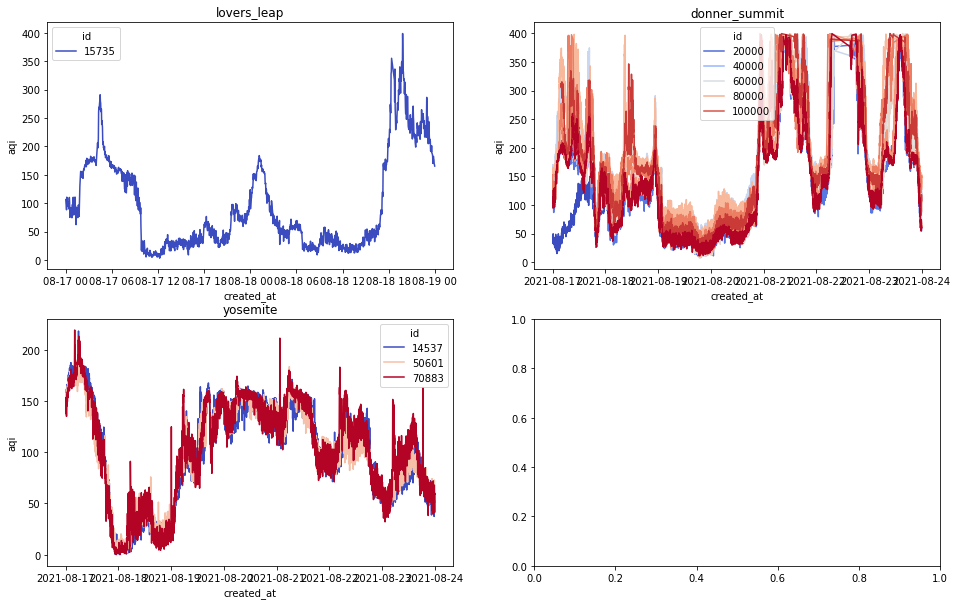

In [21]:
plt_col = round(len(hist_data['site'].unique())/2) #round up for number of columns

fig, axes = plt.subplots(ncols=plt_col, nrows=2,figsize=(16,10)) #create a subplot for each site
for i, ax in zip(hist_data['site'].unique(), axes.flat):
    temp_data = pd.DataFrame()
    temp_data = hist_data[hist_data['site']==i]
    sns.lineplot(y='aqi', x=temp_data.index,data=temp_data,hue='id', ax=ax,palette='coolwarm').set(title=i)
plt.show()


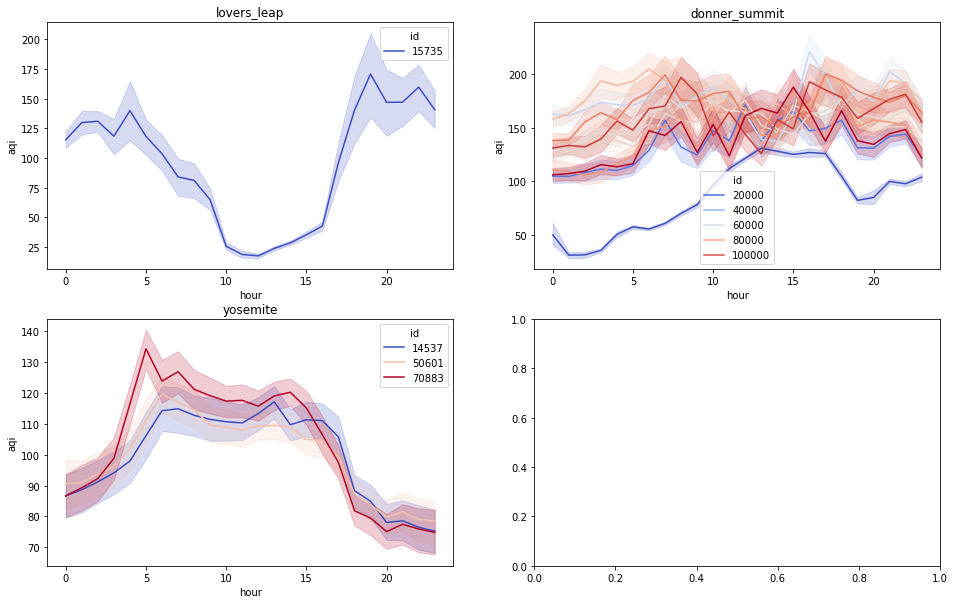

In [22]:
plt_col = round(len(hist_data['site'].unique())/2) #round up for number of columns

fig, axes = plt.subplots(ncols=plt_col, nrows=2,figsize=(16,10)) #create a subplot for each site
for i, ax in zip(hist_data['site'].unique(), axes.flat):
    temp_data = pd.DataFrame()
    temp_data = hist_data[hist_data['site']==i]
    sns.lineplot(y='aqi', x='hour',data=temp_data, hue='id', ax=ax,palette='coolwarm').set(title=i)
plt.show()

In [24]:
hist_data.groupby(['site','id'])['aqi'].mean()

site           id    
donner_summit  13265      85.776603
               22761     134.025887
               54529     176.319254
               63157     156.105336
               67195     149.944621
               77637     179.027376
               86161     141.643734
               91763     170.033062
               104014    160.331090
               110014    139.061805
lovers_leap    15735      94.657009
yosemite       14537      99.493292
               50601      99.537000
               70883     103.453363
Name: aqi, dtype: float64